In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
from scipy import interp

import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler, label_binarize, LabelBinarizer
from sklearn.metrics import r2_score, f1_score, accuracy_score, roc_auc_score, roc_curve, auc, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier

import xgboost as xgb
from xgboost import XGBClassifier

import catboost as cb
from catboost import CatBoostClassifier

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.options.mode.chained_assignment = None

Корректируем датасет:  
1) корректировка используемого в модели значения капитализации и разницы логарифмов между раундами  
2) исключение раундов "без ответа"  
3) приведение дат к нужному формату

In [2]:
default_exit_value = 1 #"капитализация" мертвой компании в долларах

dataset = pd.read_csv('C:/Users/Barca/Desktop/GitHub/IPO_Analysis/model_ver_based_on_2019/wave_2/1_DataPreparation/funding_rounds_with_exits.csv')
DEMO_SET = pd.read_csv('C:/Users/Barca/Desktop/GitHub/IPO_Analysis/model_ver_based_on_2019/wave_2/1_DataPreparation/DEMO_SET.csv')
DEMO_SET2 = pd.read_csv('C:/Users/Barca/Desktop/GitHub/IPO_Analysis/model_ver_based_on_2019/wave_2/1_DataPreparation/DEMO_SET2.csv')
DEMO_SET_ALL = pd.read_csv('C:/Users/Barca/Desktop/GitHub/IPO_Analysis/model_ver_based_on_2019/wave_2/1_DataPreparation/DEMO_SET_ALL.csv')

nasd = pd.read_excel('NASDAQ all v3.xlsx', sheet_name = 3)
nasd['Deflator_1M'] = nasd['Deflator'].shift(30)
nasd.loc[nasd['Deflator_1M'].isin([np.nan]), 'Deflator_1M'] = nasd['Deflator']
nasd['Deflator_3M'] = nasd['Deflator'].shift(90)
nasd.loc[nasd['Deflator_3M'].isin([np.nan]), 'Deflator_3M'] = nasd['Deflator']
nasd['Deflator_6M'] = nasd['Deflator'].shift(180)
nasd.loc[nasd['Deflator_6M'].isin([np.nan]), 'Deflator_6M'] = nasd['Deflator']
nasd['Deflator_9M'] = nasd['Deflator'].shift(270)
nasd.loc[nasd['Deflator_9M'].isin([np.nan]), 'Deflator_9M'] = nasd['Deflator']
nasd

,Date,Close,Change to 01-01-2009,Deflator,Deflator_1M,Deflator_3M,Deflator_6M,Deflator_9M
0,2000-01-01,4069.310059,2.580363,0.947930,0.947930,0.947930,0.947930,0.947930
1,2000-01-02,4069.310059,2.580363,0.947930,0.947930,0.947930,0.947930,0.947930
2,2000-01-03,4131.149902,2.619576,0.963012,0.963012,0.963012,0.963012,0.963012
3,2000-01-04,3901.689941,2.474075,0.905866,0.905866,0.905866,0.905866,0.905866
4,2000-01-05,3877.540039,2.458761,0.899658,0.899658,0.899658,0.899658,0.899658
...,...,...,...,...,...,...,...,...
6738,2018-06-13,7695.700195,4.879869,1.585118,1.547465,1.556922,1.481266,1.408300
6739,2018-06-14,7761.040039,4.921301,1.593573,1.539379,1.556955,1.481266,1.408300
6740,2018-06-15,7746.379883,4.912005,1.591682,1.545707,1.556955,1.481266,1.409256
6741,2018-06-16,7746.379883,4.912005,1.591682,1.543565,1.556955,1.489618,1.410290


In [3]:
dataset['announced_on'] = pd.to_datetime(dataset['announced_on'])
dataset = dataset.merge(nasd[['Date', 'Deflator', 'Deflator_1M', 'Deflator_3M', 'Deflator_6M', 'Deflator_9M']], how = 'left', left_on = 'announced_on', right_on = 'Date')
dataset

,funding_round_uuid,company_name,company_uuid,investment_type,announced_on,raised_amount_usd,post_money_valuation_usd,exit_date,exit_type,price_usd,money_raised_usd,time_from_start,time_from_previous,industry,top_investor,other_investor,top_investor_count,other_investor_count,top_investor_sum,other_investor_sum,top_investor_rounds,other_investor_rounds,Date,Deflator,Deflator_1M,Deflator_3M,Deflator_6M,Deflator_9M
0,778db45f-e9d1-3f73-86f4-ae4cc79c48ff,Lot18,003d89d4-47dc-e35a-ddf6-eda9940f3ba7,seed,2010-01-01,500000.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,2010-01-01,0.363862,0.326086,0.261374,0.130308,0.018645
1,fc2c2560-8bb0-90d1-b048-ee9cfc3f301d,Lot18,003d89d4-47dc-e35a-ddf6-eda9940f3ba7,series_a,2010-11-10,3000000.0,NaN,NaN,NaN,NaN,NaN,313.0,313.0,1.0,1.0,0.0,3.0,2.0,6.0,2.0,3.0,1.0,2010-11-10,0.491773,0.420896,0.328481,0.397531,0.325399
2,d863a1b9-dda0-284e-3258-fa43a20d305c,Lot18,003d89d4-47dc-e35a-ddf6-eda9940f3ba7,series_b,2011-05-02,10000000.0,NaN,NaN,NaN,NaN,NaN,486.0,173.0,1.0,1.0,0.0,3.0,2.0,6.0,2.0,3.0,1.0,2011-05-02,0.596704,0.570355,0.556490,0.476727,0.374344
3,4c9cb685-ec9a-92ed-64c0-062040d9573e,Lot18,003d89d4-47dc-e35a-ddf6-eda9940f3ba7,series_unknown,2011-08-24,1000000.0,NaN,NaN,NaN,NaN,NaN,600.0,114.0,1.0,0.0,1.0,3.0,2.0,6.0,2.0,3.0,1.0,2011-08-24,0.447739,0.589246,0.567957,0.567285,0.474477
4,1006ef75-d2f2-bac4-5737-dae2075cf616,Lot18,003d89d4-47dc-e35a-ddf6-eda9940f3ba7,series_c,2011-11-04,30000000.0,NaN,NaN,NaN,NaN,NaN,672.0,72.0,1.0,1.0,0.0,3.0,2.0,6.0,2.0,3.0,1.0,2011-11-04,0.532566,0.444825,0.473628,0.583871,0.568342
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7562,2067db69-a274-7914-0207-5fb1af6cc7ca,ZS Pharma,ffd3e2ec-f764-6135-4b41-9a861965223d,series_c,2012-10-23,46000000.0,NaN,2014-06-19,ipo,300000000.0,112000000.0,679.0,673.0,2.0,1.0,1.0,5.0,5.0,6.0,10.0,2.0,3.0,2012-10-23,0.639884,0.701325,0.593262,0.659798,0.579969
7563,602347ee-2d81-7ad3-7f85-d68ea1fb8967,ZS Pharma,ffd3e2ec-f764-6135-4b41-9a861965223d,series_d,2014-03-05,55000000.0,NaN,2014-06-19,ipo,300000000.0,112000000.0,1177.0,498.0,2.0,1.0,1.0,5.0,5.0,6.0,10.0,2.0,3.0,2014-03-05,1.016463,0.929991,0.939009,0.841923,0.788386
7564,-,ZS Pharma,ffd3e2ec-f764-6135-4b41-9a861965223d,ipo,2014-06-19,112000000.0,300000000.0,2014-06-19,ipo,300000000.0,112000000.0,1283.0,106.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,3.0,2014-06-19,1.016775,0.954685,0.997659,0.956599,0.872786
7565,7792bf54-78d8-7159-329b-41e71e1c8f6b,Powermat Technologies,fff473e3-0f7d-b475-1da2-c9496721f49f,series_c,2011-10-06,80000000.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,1.0,0.0,1.0,0.0,2.0,0.0,2.0,0.0,1.0,2011-10-06,0.463472,0.450224,0.595212,0.567059,0.538882


In [4]:
dataset['post_money_valuation_usd'] = pd.to_numeric(dataset['post_money_valuation_usd'], errors='coerce')
dataset.loc[dataset['post_money_valuation_usd'].isin([np.nan]), 'post_money_valuation_usd'] = 0
dataset['raised_amount_usd'] = pd.to_numeric(dataset['raised_amount_usd'], errors='coerce')
dataset.loc[dataset['raised_amount_usd'].isin([np.nan]), 'raised_amount_usd'] = 0
dataset['interpolated_money_valuation_usd'] = round(dataset['raised_amount_usd'] ** 1.1187, -6) #1.12751583465595
dataset.loc[(dataset['raised_amount_usd'] ** 1.1187 < 1000000) & (dataset['raised_amount_usd'] != 0), 'interpolated_money_valuation_usd'] = 1000000
dataset['interpolated_money_valuation_usd'] = pd.to_numeric(dataset['interpolated_money_valuation_usd'], errors='coerce')
dataset.loc[dataset['interpolated_money_valuation_usd'].isin([np.nan]), 'interpolated_money_valuation_usd'] = 0
dataset['valuation'] = dataset['interpolated_money_valuation_usd']
dataset.loc[dataset['valuation'] == 0, 'valuation'] = dataset['post_money_valuation_usd']
dataset.loc[dataset['investment_type'] == 'death', 'valuation'] = default_exit_value

dataset['total_sum_raised'] = dataset.groupby(['company_uuid'])['raised_amount_usd'].transform('cumsum')
dataset['total_sum_raised_before'] = dataset.groupby('company_uuid')['total_sum_raised'].shift(1)
dataset.loc[dataset['total_sum_raised_before'].isin([np.nan]), 'total_sum_raised_before'] = 0

dataset = dataset.replace('---', np.nan)
dataset.loc[(dataset['exit_type'].isin([np.nan])) | (dataset['exit_type'] == '0'), 'exit_type'] = 'dead'
dataset.loc[dataset['exit_type'] == 'dead', 'not_dead'] = 0
dataset.loc[dataset['exit_type'].isin(['sold', 'ipo']), 'not_dead'] = 1

dataset['announced_on'] = pd.to_datetime(dataset['announced_on'])
dataset['time_from_previous'] = pd.to_numeric(dataset['time_from_previous'], errors='coerce')
dataset.loc[dataset['time_from_previous'].isin([np.nan]), 'time_from_previous'] = 0
#добавляем скорость роста капитализации (исключаются все первые раунды в серии, необходимо 2+ раунда с ненулевой капитализацией)
dataset.loc[dataset['valuation'] != 0, 'val_log'] = np.log(dataset['valuation'])
dataset = dataset.loc[~dataset['val_log'].isin([np.nan])]
dataset['log_delta'] = dataset.groupby(['company_uuid'])['val_log'].diff()
dataset = dataset.loc[~dataset['log_delta'].isin([np.nan])]
dataset['val_rate'] = dataset['log_delta'] * (365 / dataset['time_from_previous'])
dataset.loc[dataset['total_sum_raised_before'] != 0, 'sum_raised_log'] = np.log(dataset['total_sum_raised_before'])
dataset = dataset.loc[~dataset['sum_raised_log'].isin([np.nan])]

#listColumns = ['top_quantil', 'is_PHD', 'is_Master', 'is_MBA']
#for i in listColumns:
#    dataset[i] = dataset[i].replace(np.nan, 0)

#for i in dataset.columns:
#    if i.startswith('EDU_'):
#        dataset[i] = pd.to_numeric(dataset[i], errors='coerce')
#        dataset.loc[dataset[i] != 0, i] = 1

y = dataset.loc[dataset['investment_type'].isin(['ipo', 'sold', 'death'])] #экзиты
dataset

C:\Users\Barca\anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,funding_round_uuid,company_name,company_uuid,investment_type,announced_on,raised_amount_usd,post_money_valuation_usd,exit_date,exit_type,price_usd,money_raised_usd,time_from_start,time_from_previous,industry,top_investor,other_investor,top_investor_count,other_investor_count,top_investor_sum,other_investor_sum,top_investor_rounds,other_investor_rounds,Date,Deflator,Deflator_1M,Deflator_3M,Deflator_6M,Deflator_9M,interpolated_money_valuation_usd,valuation,total_sum_raised,total_sum_raised_before,not_dead,val_log,log_delta,val_rate,sum_raised_log
1,fc2c2560-8bb0-90d1-b048-ee9cfc3f301d,Lot18,003d89d4-47dc-e35a-ddf6-eda9940f3ba7,series_a,2010-11-10,3000000.0,0.0,NaN,dead,NaN,NaN,313.0,313.0,1.0,1.0,0.0,3.0,2.0,6.0,2.0,3.0,1.0,2010-11-10,0.491773,0.420896,0.328481,0.397531,0.325399,1.800000e+07,1.800000e+07,3500000.0,500000.0,0.0,16.705882,2.197225,2.562259,13.122363
2,d863a1b9-dda0-284e-3258-fa43a20d305c,Lot18,003d89d4-47dc-e35a-ddf6-eda9940f3ba7,series_b,2011-05-02,10000000.0,0.0,NaN,dead,NaN,NaN,486.0,173.0,1.0,1.0,0.0,3.0,2.0,6.0,2.0,3.0,1.0,2011-05-02,0.596704,0.570355,0.556490,0.476727,0.374344,6.800000e+07,6.800000e+07,13500000.0,3500000.0,0.0,18.035018,1.329136,2.804246,15.068274
3,4c9cb685-ec9a-92ed-64c0-062040d9573e,Lot18,003d89d4-47dc-e35a-ddf6-eda9940f3ba7,series_unknown,2011-08-24,1000000.0,0.0,NaN,dead,NaN,NaN,600.0,114.0,1.0,0.0,1.0,3.0,2.0,6.0,2.0,3.0,1.0,2011-08-24,0.447739,0.589246,0.567957,0.567285,0.474477,5.000000e+06,5.000000e+06,14500000.0,13500000.0,0.0,15.424948,-2.610070,-8.356802,16.418200
4,1006ef75-d2f2-bac4-5737-dae2075cf616,Lot18,003d89d4-47dc-e35a-ddf6-eda9940f3ba7,series_c,2011-11-04,30000000.0,0.0,NaN,dead,NaN,NaN,672.0,72.0,1.0,1.0,0.0,3.0,2.0,6.0,2.0,3.0,1.0,2011-11-04,0.532566,0.444825,0.473628,0.583871,0.568342,2.320000e+08,2.320000e+08,44500000.0,14500000.0,0.0,19.262248,3.837299,19.452976,16.489659
5,-,Lot18,003d89d4-47dc-e35a-ddf6-eda9940f3ba7,death,2015-05-02,0.0,0.0,NaN,dead,NaN,NaN,1947.0,1275.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,2015-05-02,1.154972,1.131023,1.078145,1.078936,1.015285,0.000000e+00,1.000000e+00,44500000.0,44500000.0,0.0,0.000000,-19.262248,-5.514291,17.611000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7561,e79c29e1-b5a7-db70-014d-36c2ba16338b,ZS Pharma,ffd3e2ec-f764-6135-4b41-9a861965223d,series_unknown,2010-12-20,792000.0,0.0,2014-06-19,ipo,300000000.0,112000000.0,6.0,6.0,2.0,0.0,1.0,5.0,5.0,6.0,10.0,2.0,3.0,2010-12-20,0.518850,0.467969,0.398595,0.357265,0.418846,4.000000e+06,4.000000e+06,1987972.0,1195972.0,1.0,15.201805,-0.405465,-24.665794,13.994470
7562,2067db69-a274-7914-0207-5fb1af6cc7ca,ZS Pharma,ffd3e2ec-f764-6135-4b41-9a861965223d,series_c,2012-10-23,46000000.0,0.0,2014-06-19,ipo,300000000.0,112000000.0,679.0,673.0,2.0,1.0,1.0,5.0,5.0,6.0,10.0,2.0,3.0,2012-10-23,0.639884,0.701325,0.593262,0.659798,0.579969,3.740000e+08,3.740000e+08,47987972.0,1987972.0,1.0,19.739766,4.537961,2.461153,14.502626
7563,602347ee-2d81-7ad3-7f85-d68ea1fb8967,ZS Pharma,ffd3e2ec-f764-6135-4b41-9a861965223d,series_d,2014-03-05,55000000.0,0.0,2014-06-19,ipo,300000000.0,112000000.0,1177.0,498.0,2.0,1.0,1.0,5.0,5.0,6.0,10.0,2.0,3.0,2014-03-05,1.016463,0.929991,0.939009,0.841923,0.788386,4.560000e+08,4.560000e+08,102987972.0,47987972.0,1.0,19.938003,0.198237,0.145294,17.686461
7564,-,ZS Pharma,ffd3e2ec-f764-6135-4b41-9a861965223d,ipo,2014-06-19,112000000.0,300000000.0,2014-06-19,ipo,300000000.0,112000000.0,1283.0,106.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,3.0,2014-06-19,1.016775,0.954685,0.997659,0.956599,0.872786,1.011000e+09,1.011000e+09,214987972.0,102987972.0,1.0,20.734206,0.796202,2.741640,18.450123


Разбиваем на классы

In [5]:
y['val_rate'].describe([.5])

count    1246.000000
mean       -1.008579
std        14.400395
min       -21.510264
50%        -4.641485
max       343.241723
Name: val_rate, dtype: float64

In [6]:
y.groupby('investment_type').size()

investment_type
death    636
ipo      328
sold     282
dtype: int64

Все, что слева от медианного значения -1.008579 - нарвалы (с отрицательной скоростью роста привлеченных средств), справа - носороги (с положительной и околонулевой скоростью роста привлеченных средств)

In [7]:
dataset = dataset.loc[dataset['company_uuid'].isin(y['company_uuid'].values)]
dataset.loc[dataset.groupby('company_uuid')['val_rate'].shift(-1) <= -1.008579, 'class'] = 'narwhal'
dataset.loc[dataset.groupby('company_uuid')['val_rate'].shift(-1) > -1.008579, 'class'] = 'rhino'

additional = dataset.set_index('funding_round_uuid').groupby('company_uuid')['announced_on'].nlargest(2).reset_index()
dataset = dataset.loc[dataset['funding_round_uuid'].isin(additional['funding_round_uuid'].values)]
exits = dataset.copy()
dataset = dataset.loc[~dataset['investment_type'].isin(['ipo', 'sold', 'death'])] #преэкзиты
dataset

,funding_round_uuid,company_name,company_uuid,investment_type,announced_on,raised_amount_usd,post_money_valuation_usd,exit_date,exit_type,price_usd,money_raised_usd,time_from_start,time_from_previous,industry,top_investor,other_investor,top_investor_count,other_investor_count,top_investor_sum,other_investor_sum,top_investor_rounds,other_investor_rounds,Date,Deflator,Deflator_1M,Deflator_3M,Deflator_6M,Deflator_9M,interpolated_money_valuation_usd,valuation,total_sum_raised,total_sum_raised_before,not_dead,val_log,log_delta,val_rate,sum_raised_log,class
4,1006ef75-d2f2-bac4-5737-dae2075cf616,Lot18,003d89d4-47dc-e35a-ddf6-eda9940f3ba7,series_c,2011-11-04,30000000.0,0.0,NaN,dead,NaN,NaN,672.0,72.0,1.0,1.0,0.0,3.0,2.0,6.0,2.0,3.0,1.0,2011-11-04,0.532566,0.444825,0.473628,0.583871,0.568342,2.320000e+08,2.320000e+08,44500000.0,14500000.0,0.0,19.262248,3.837299,19.452976,16.489659,narwhal
9,d17e816a-f9d4-8dde-270f-71d46a10f28e,Xcovery,0041fccf-ebbb-48ad-3091-b94350ef4d7c,private_equity,2014-10-29,20000000.0,0.0,NaN,dead,NaN,NaN,1094.0,194.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,2014-10-29,1.059415,1.049833,1.019167,0.961256,0.956389,1.470000e+08,1.470000e+08,30796170.0,10796170.0,0.0,18.805943,2.351375,4.423979,16.194702,narwhal
13,a9a651a1-7849-9329-e97a-8ce957637b71,CardiAQ Valve Technologies,009e8957-d102-c674-6c9c-98eb11ac8e32,series_b,2012-11-29,37300000.0,0.0,2015-07-10,sold,3.500000e+08,NaN,1296.0,1052.0,2.0,1.0,0.0,2.0,1.0,2.0,1.0,1.0,1.0,2012-11-29,0.647071,0.639044,0.665143,0.555141,0.635101,2.950000e+08,2.950000e+08,44550000.0,7250000.0,1.0,19.502486,1.949306,0.676328,15.796512,rhino
20,951e44e7-27c6-b933-eb05-160c03705497,CellBiosciences,00e12273-bfa7-d0ac-25e2-c870ab22c474,series_f,2010-10-14,20000000.0,0.0,2014-06-17,sold,3.000000e+08,NaN,1747.0,297.0,2.0,1.0,1.0,7.0,4.0,16.0,8.0,4.0,3.0,2010-10-14,0.434559,0.372908,0.323346,0.453223,0.372130,1.470000e+08,1.470000e+08,85249999.0,65249999.0,1.0,18.805943,0.863298,1.060956,17.993737,rhino
30,fb9fe2de-8074-a467-9ed3-1bd9b2f5c66b,Verdezyne,0133e167-b2b5-b665-c76c-e2a65203263d,series_unknown,2014-03-28,48000000.0,0.0,NaN,dead,NaN,NaN,3200.0,1053.0,3.0,0.0,1.0,0.0,10.0,0.0,25.0,0.0,7.0,2014-03-28,0.968952,1.001223,0.969152,0.874601,0.778325,3.920000e+08,3.920000e+08,69853000.0,21853000.0,0.0,19.786772,1.876917,0.650593,16.899849,narwhal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7534,4311ddf1-9db9-6dbb-e011-86df3f2161d8,Complete Genomics,fef181ac-2e1a-a041-8ac3-387a89571a7f,series_e,2010-08-19,39000000.0,0.0,2011-09-16,ipo,2.322000e+08,54000000.0,1605.0,360.0,2.0,1.0,1.0,4.0,3.0,8.0,7.0,2.0,3.0,2010-08-19,0.323300,0.343085,0.346028,0.352659,0.308081,3.110000e+08,3.110000e+08,128500000.0,89500000.0,1.0,19.555303,-0.157361,-0.159547,18.309749,rhino
7544,c9114172-7a01-695f-7c32-2807c58cd8a7,Juno Therapeutics,ff429091-2166-c3b5-409d-6e779fee09f5,series_b,2014-08-05,134000000.0,0.0,2014-12-19,ipo,1.675700e+09,264600000.0,245.0,103.0,2.0,1.0,1.0,2.0,2.0,4.0,4.0,3.0,3.0,2014-08-05,1.015285,1.045403,0.947527,0.944930,0.910352,1.235000e+09,1.235000e+09,310000000.0,176000000.0,1.0,20.934337,0.976789,3.461436,18.985995,rhino
7549,32ea83d9-9fe1-c480-c503-25eece562607,Aster Data Systems,ff65b5a2-e2f4-1557-b091-e93dfe88873e,series_c,2010-09-22,30000000.0,0.0,2011-03-03,sold,2.630000e+08,NaN,1786.0,574.0,1.0,1.0,1.0,5.0,4.0,11.0,7.0,4.0,4.0,2010-09-22,0.392276,0.314394,0.340801,0.417894,0.371125,2.320000e+08,2.320000e+08,53000000.0,23000000.0,1.0,19.262248,0.634553,0.403505,16.951005,rhino
7558,f46a723f-9820-3fbe-e97f-f5919b2f4a7f,Fisoc,ff7cac81-4ec2-eace-bcb4-faea16a8cf84,series_unknown,2014-04-01,19000000.0,0.0,NaN,dead,NaN,NaN,1391.0,186.0,4.0,1.0,1.0,2.0,2.0,6.0,5.0,4.0,4.0,2014-04-01,0.995611,1.004958,0.973952,0.872682,0.791311,1.390000e+08,1.390000e+08,50178429.0,31178429.0,0.0,18.749984,-0.108951,-0.213802,17.255237,narwhal


In [8]:
# ipos = pd.read_csv('F:/Project/csv/ipos.csv')
# ipos = ipos.drop(ipos[ipos['ipo_uuid'] == '78661dee-2311-22d5-097f-e86638bfc419'].index)
# ipos = ipos.drop(ipos[ipos['ipo_uuid'] == 'b4636bcd-d740-4ed6-d167-e3e7cd692fb6'].index)
# ipos = ipos.drop(ipos[ipos['ipo_uuid'] == 'dec69efa-2c13-7e14-290f-06caf1d248c1'].index)
# a = dataset.loc[dataset['exit_type'] == 'ipo']
# ipos = ipos.loc[ipos['company_uuid'].isin(a['company_uuid'])]
# ipos.to_csv('ipos_2018.csv', index=False, encoding = 'utf-8-sig')
# ipos

In [9]:
dataset.groupby('not_dead').size()

not_dead
0.0    427
1.0    550
dtype: int64

In [10]:
dataset.groupby('exit_type').size()

exit_type
dead    427
ipo     307
sold    243
dtype: int64

In [11]:
exits = exits.loc[(exits['investment_type'].isin(['ipo', 'sold', 'death'])) & (exits['company_uuid'].isin(dataset['company_uuid']))] #экзиты
exits.loc[exits['val_rate'] <= -1.008579, 'class'] = 'narwhal'
exits.loc[exits['val_rate'] > -1.008579, 'class'] = 'rhino'
exits

,funding_round_uuid,company_name,company_uuid,investment_type,announced_on,raised_amount_usd,post_money_valuation_usd,exit_date,exit_type,price_usd,money_raised_usd,time_from_start,time_from_previous,industry,top_investor,other_investor,top_investor_count,other_investor_count,top_investor_sum,other_investor_sum,top_investor_rounds,other_investor_rounds,Date,Deflator,Deflator_1M,Deflator_3M,Deflator_6M,Deflator_9M,interpolated_money_valuation_usd,valuation,total_sum_raised,total_sum_raised_before,not_dead,val_log,log_delta,val_rate,sum_raised_log,class
5,-,Lot18,003d89d4-47dc-e35a-ddf6-eda9940f3ba7,death,2015-05-02,0.0,0.000000e+00,NaN,dead,NaN,NaN,1947.0,1275.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,2015-05-02,1.154972,1.131023,1.078145,1.078936,1.015285,0.000000e+00,1.000000e+00,44500000.0,44500000.0,0.0,0.000000,-19.262248,-5.514291,17.611000,narwhal
10,-,Xcovery,0041fccf-ebbb-48ad-3091-b94350ef4d7c,death,2018-04-26,0.0,0.000000e+00,NaN,dead,NaN,NaN,2369.0,1275.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2018-04-26,1.507179,1.491625,1.560129,1.446752,1.396791,0.000000e+00,1.000000e+00,30796170.0,30796170.0,0.0,0.000000,-18.805943,-5.383662,17.242901,narwhal
14,-,CardiAQ Valve Technologies,009e8957-d102-c674-6c9c-98eb11ac8e32,sold,2015-07-10,0.0,3.500000e+08,2015-07-10,sold,3.500000e+08,NaN,2249.0,953.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2015-07-10,1.153434,1.169116,1.153090,1.092885,0.982788,0.000000e+00,3.500000e+08,44550000.0,44550000.0,1.0,19.673444,0.170958,0.065477,17.612123,rhino
21,-,CellBiosciences,00e12273-bfa7-d0ac-25e2-c870ab22c474,sold,2014-06-17,0.0,3.000000e+08,2014-06-17,sold,3.000000e+08,NaN,3089.0,1342.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,3.0,2014-06-17,1.011693,0.953146,1.004838,0.945181,0.872786,0.000000e+00,3.000000e+08,85249999.0,85249999.0,1.0,19.519293,0.713350,0.194018,18.261099,rhino
31,-,Verdezyne,0133e167-b2b5-b665-c76c-e2a65203263d,death,2017-09-23,0.0,0.000000e+00,NaN,dead,NaN,NaN,4475.0,1275.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,2017-09-23,1.404952,1.380445,1.379475,1.309251,1.246918,0.000000e+00,1.000000e+00,69853000.0,69853000.0,0.0,0.000000,-19.786772,-5.664449,18.061904,narwhal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7535,-,Complete Genomics,fef181ac-2e1a-a041-8ac3-387a89571a7f,ipo,2011-09-16,54000000.0,2.322000e+08,2011-09-16,ipo,2.322000e+08,54000000.0,1998.0,393.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,3.0,2011-09-16,0.508512,0.465329,0.506287,0.516625,0.518850,4.470000e+08,4.470000e+08,182500000.0,128500000.0,1.0,19.918069,0.362766,0.336920,18.671439,rhino
7545,-,Juno Therapeutics,ff429091-2166-c3b5-409d-6e779fee09f5,ipo,2014-12-19,264600000.0,1.675700e+09,2014-12-19,ipo,1.675700e+09,264600000.0,381.0,136.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,2014-12-19,1.105834,1.086838,1.066110,1.018771,0.985805,2.645000e+09,2.645000e+09,574600000.0,310000000.0,1.0,21.695937,0.761600,2.044000,19.552083,rhino
7550,-,Aster Data Systems,ff65b5a2-e2f4-1557-b091-e93dfe88873e,sold,2011-03-03,0.0,2.630000e+08,2011-03-03,sold,2.630000e+08,NaN,1948.0,162.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0,2011-03-03,0.573626,0.556490,0.496678,0.348138,0.341590,0.000000e+00,2.630000e+08,53000000.0,53000000.0,1.0,19.387665,0.125417,0.282575,17.785802,rhino
7559,-,Fisoc,ff7cac81-4ec2-eace-bcb4-faea16a8cf84,death,2017-09-27,0.0,0.000000e+00,NaN,dead,NaN,NaN,2666.0,1275.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0,2017-09-27,1.409042,1.382307,1.359990,1.321397,1.227725,0.000000e+00,1.000000e+00,50178429.0,50178429.0,0.0,0.000000,-18.749984,-5.367643,17.731096,narwhal


In [12]:
dataset.groupby('class').size()

class
narwhal    449
rhino      528
dtype: int64

Выравниваем количество сэмплов в классах

In [13]:
#np.random.seed(10)
#remove_n = 63
#
#df = dataset.loc[dataset['class'] == 'rhino']
#drop_indices = np.random.choice(df.index, remove_n, replace=False)
#dataset = dataset.drop(drop_indices)
#dataset.groupby('class').size()

In [14]:
# DEMO_SET['raised_amount_usd'] = pd.to_numeric(DEMO_SET['raised_amount_usd'], errors='coerce')
# DEMO_SET.loc[DEMO_SET['raised_amount_usd'].isin([np.nan]), 'raised_amount_usd'] = 0
# DEMO_SET['interpolated_money_valuation_usd'] = round(DEMO_SET['raised_amount_usd'] ** 1.1187, -6) #1.12751583465595
# DEMO_SET['interpolated_money_valuation_usd'] = pd.to_numeric(DEMO_SET['interpolated_money_valuation_usd'], errors='coerce')
# DEMO_SET.loc[DEMO_SET['interpolated_money_valuation_usd'].isin([np.nan]), 'interpolated_money_valuation_usd'] = 0
# DEMO_SET['post_money_valuation_usd'] = pd.to_numeric(DEMO_SET['post_money_valuation_usd'], errors='coerce')
# DEMO_SET.loc[DEMO_SET['post_money_valuation_usd'].isin([np.nan]), 'post_money_valuation_usd'] = 0

# DEMO_SET['total_sum_raised'] = DEMO_SET.groupby(['company_uuid'])['raised_amount_usd'].transform('cumsum')
# DEMO_SET['total_sum_raised_before'] = DEMO_SET.groupby('company_uuid')['total_sum_raised'].shift(1)

# DEMO_SET['valuation'] = DEMO_SET['interpolated_money_valuation_usd']
# DEMO_SET.loc[DEMO_SET['valuation'] == 0, 'valuation'] = DEMO_SET['post_money_valuation_usd']
# DEMO_SET.loc[DEMO_SET['investment_type'] == 'death', 'valuation'] = default_exit_value

# DEMO_SET.loc[DEMO_SET['valuation'] != 0, 'val_log'] = np.log(DEMO_SET['valuation'])
# DEMO_SET = DEMO_SET.loc[~DEMO_SET['val_log'].isin([np.nan])]
# DEMO_SET['log_delta'] = DEMO_SET.groupby(['company_uuid'])['val_log'].diff()
# DEMO_SET = DEMO_SET.loc[~DEMO_SET['log_delta'].isin([np.nan])]

# DEMO_SET = DEMO_SET.replace('---', np.nan)
# DEMO_SET['announced_on'] = pd.to_datetime(DEMO_SET['announced_on'])
# DEMO_SET['log_delta'] = pd.to_numeric(DEMO_SET['log_delta'], errors='coerce')
# DEMO_SET['time_from_previous'] = pd.to_numeric(DEMO_SET['time_from_previous'], errors='coerce')
# DEMO_SET['val_rate'] = DEMO_SET['log_delta'] * (365 / DEMO_SET['time_from_previous'])

# DEMO_SET = DEMO_SET.loc[DEMO_SET.groupby(['company_uuid'])['announced_on'].idxmax()]
# DEMO_SET

In [15]:
# DEMO_SET2['raised_amount_usd'] = pd.to_numeric(DEMO_SET2['raised_amount_usd'], errors='coerce')
# DEMO_SET2.loc[DEMO_SET2['raised_amount_usd'].isin([np.nan]), 'raised_amount_usd'] = 0
# DEMO_SET2['interpolated_money_valuation_usd'] = round(DEMO_SET2['raised_amount_usd'] ** 1.1187, -6) #1.12751583465595
# DEMO_SET2['interpolated_money_valuation_usd'] = pd.to_numeric(DEMO_SET2['interpolated_money_valuation_usd'], errors='coerce')
# DEMO_SET2.loc[DEMO_SET2['interpolated_money_valuation_usd'].isin([np.nan]), 'interpolated_money_valuation_usd'] = 0
# DEMO_SET2['post_money_valuation_usd'] = pd.to_numeric(DEMO_SET2['post_money_valuation_usd'], errors='coerce')
# DEMO_SET2.loc[DEMO_SET2['post_money_valuation_usd'].isin([np.nan]), 'post_money_valuation_usd'] = 0

# DEMO_SET2['total_sum_raised'] = DEMO_SET2.groupby(['company_uuid'])['raised_amount_usd'].transform('cumsum')
# DEMO_SET2['total_sum_raised_before'] = DEMO_SET2.groupby('company_uuid')['total_sum_raised'].shift(1)

# DEMO_SET2['valuation'] = DEMO_SET2['interpolated_money_valuation_usd']
# DEMO_SET2.loc[DEMO_SET2['valuation'] == 0, 'valuation'] = DEMO_SET2['post_money_valuation_usd']
# DEMO_SET2.loc[DEMO_SET2['investment_type'] == 'death', 'valuation'] = default_exit_value

# DEMO_SET2.loc[DEMO_SET2['valuation'] != 0, 'val_log'] = np.log(DEMO_SET2['valuation'])
# DEMO_SET2 = DEMO_SET2.loc[~DEMO_SET2['val_log'].isin([np.nan])]
# DEMO_SET2['log_delta'] = DEMO_SET2.groupby(['company_uuid'])['val_log'].diff()
# DEMO_SET2 = DEMO_SET2.loc[~DEMO_SET2['log_delta'].isin([np.nan])]

# DEMO_SET2 = DEMO_SET2.replace('---', np.nan)
# DEMO_SET2['announced_on'] = pd.to_datetime(DEMO_SET2['announced_on'])
# DEMO_SET2['log_delta'] = pd.to_numeric(DEMO_SET2['log_delta'], errors='coerce')
# DEMO_SET2['time_from_previous'] = pd.to_numeric(DEMO_SET2['time_from_previous'], errors='coerce')
# DEMO_SET2['val_rate'] = DEMO_SET2['log_delta'] * (365 / DEMO_SET2['time_from_previous'])

# DEMO_SET2 = DEMO_SET2.loc[DEMO_SET2.groupby(['company_uuid'])['announced_on'].idxmax()]
# DEMO_SET2

In [16]:
# DEMO_SET_ALL['raised_amount_usd'] = pd.to_numeric(DEMO_SET_ALL['raised_amount_usd'], errors='coerce')
# DEMO_SET_ALL.loc[DEMO_SET_ALL['raised_amount_usd'].isin([np.nan]), 'raised_amount_usd'] = 0
# DEMO_SET_ALL['interpolated_money_valuation_usd'] = round(DEMO_SET_ALL['raised_amount_usd'] ** 1.1187, -6) #1.12751583465595
# DEMO_SET_ALL.loc[(DEMO_SET_ALL['raised_amount_usd'] ** 1.1187 < 1000000) & (DEMO_SET_ALL['raised_amount_usd'] != 0), 'interpolated_money_valuation_usd'] = 1000000
# DEMO_SET_ALL['interpolated_money_valuation_usd'] = pd.to_numeric(DEMO_SET_ALL['interpolated_money_valuation_usd'], errors='coerce')
# DEMO_SET_ALL.loc[DEMO_SET_ALL['interpolated_money_valuation_usd'].isin([np.nan]), 'interpolated_money_valuation_usd'] = 0
# DEMO_SET_ALL['post_money_valuation_usd'] = pd.to_numeric(DEMO_SET_ALL['post_money_valuation_usd'], errors='coerce')
# DEMO_SET_ALL.loc[DEMO_SET_ALL['post_money_valuation_usd'].isin([np.nan]), 'post_money_valuation_usd'] = 0

# DEMO_SET_ALL['total_sum_raised'] = DEMO_SET_ALL.groupby(['company_uuid'])['raised_amount_usd'].transform('cumsum')
# DEMO_SET_ALL['total_sum_raised_before'] = DEMO_SET_ALL.groupby('company_uuid')['total_sum_raised'].shift(1)

# DEMO_SET_ALL['valuation'] = DEMO_SET_ALL['interpolated_money_valuation_usd']
# DEMO_SET_ALL.loc[DEMO_SET_ALL['valuation'] == 0, 'valuation'] = DEMO_SET_ALL['post_money_valuation_usd']
# DEMO_SET_ALL.loc[DEMO_SET_ALL['investment_type'] == 'death', 'valuation'] = default_exit_value

# DEMO_SET_ALL.loc[DEMO_SET_ALL['valuation'] != 0, 'val_log'] = np.log(DEMO_SET_ALL['valuation'])
# DEMO_SET_ALL = DEMO_SET_ALL.loc[~DEMO_SET_ALL['val_log'].isin([np.nan])]
# DEMO_SET_ALL['log_delta'] = DEMO_SET_ALL.groupby(['company_uuid'])['val_log'].diff()
# DEMO_SET_ALL = DEMO_SET_ALL.loc[~DEMO_SET_ALL['log_delta'].isin([np.nan])]

# DEMO_SET_ALL = DEMO_SET_ALL.replace('---', np.nan)
# DEMO_SET_ALL['announced_on'] = pd.to_datetime(DEMO_SET_ALL['announced_on'])
# DEMO_SET_ALL['log_delta'] = pd.to_numeric(DEMO_SET_ALL['log_delta'], errors='coerce')
# DEMO_SET_ALL['time_from_previous'] = pd.to_numeric(DEMO_SET_ALL['time_from_previous'], errors='coerce')
# DEMO_SET_ALL['val_rate'] = DEMO_SET_ALL['log_delta'] * (365 / DEMO_SET_ALL['time_from_previous'])

# DEMO_SET_ALL = DEMO_SET_ALL.loc[DEMO_SET_ALL.groupby(['company_uuid'])['announced_on'].idxmax()]
# DEMO_SET_ALL = DEMO_SET_ALL.sort_values(by=['announced_on'])
# DEMO_SET_ALL.to_csv('DEMO_SET_ALL_sorted.csv', encoding = 'utf-8-sig')
# DEMO_SET_ALL

### Матрица корреляций и графики взаимной зависимости между признаками

In [22]:
test_tab = dataset.drop(columns=['exit_type', 'class', 'funding_round_uuid', 'company_name', 'company_uuid', 'announced_on', 'raised_amount_usd', 'post_money_valuation_usd', 'interpolated_money_valuation_usd', 'exit_date', 'price_usd', 'money_raised_usd', 'total_sum_raised', 'log_delta', 'investment_type', 'Date']) #'exit_type', 'not_dead', 'class'
#test_tab.loc[test_tab['exit_type'] == 'sold', 'exit_type'] = -1
#test_tab.loc[test_tab['exit_type'] == 'dead', 'exit_type'] = 0
#test_tab.loc[test_tab['exit_type'] == 'ipo', 'exit_type'] = 1
#test_tab.loc[test_tab['class'] == 'narwhal', 'class'] = 0
#test_tab.loc[test_tab['class'] == 'rhino', 'class'] = 1
test_tab = test_tab.drop(columns=['Deflator_1M', 'Deflator_3M', 'Deflator_6M', 'Deflator_9M', 'total_sum_raised_before', 'valuation', 'top_investor', 'other_investor'])
test_tab = test_tab.astype('float')
test_tab.corr()

,time_from_start,time_from_previous,industry,top_investor_count,other_investor_count,top_investor_sum,other_investor_sum,top_investor_rounds,other_investor_rounds,Deflator,not_dead,val_log,val_rate,sum_raised_log
time_from_start,1.000000,0.321877,-0.091500,0.101623,0.179554,0.223719,0.266544,0.385811,0.459999,0.111859,0.059052,-0.033176,-0.058939,0.365307
time_from_previous,0.321877,1.000000,-0.011276,-0.093130,-0.039524,-0.114022,-0.044910,-0.134247,-0.082848,0.001394,-0.045950,0.112579,-0.022193,-0.217016
industry,-0.091500,-0.011276,1.000000,-0.167290,-0.079688,-0.174568,-0.094308,-0.172268,-0.107908,-0.102775,-0.090364,-0.055111,-0.028749,0.007533
top_investor_count,0.101623,-0.093130,-0.167290,1.000000,0.465002,0.879692,0.404576,0.646483,0.309872,0.131546,0.297535,0.350086,-0.011212,0.284984
other_investor_count,0.179554,-0.039524,-0.079688,0.465002,1.000000,0.392429,0.925351,0.356402,0.632077,0.149752,0.163123,0.300941,0.007246,0.212631
top_investor_sum,0.223719,-0.114022,-0.174568,0.879692,0.392429,1.000000,0.397505,0.774179,0.368729,0.120928,0.254110,0.227990,-0.016600,0.337639
other_investor_sum,0.266544,-0.044910,-0.094308,0.404576,0.925351,0.397505,1.000000,0.399186,0.728689,0.114307,0.156584,0.246214,-0.002119,0.253662
top_investor_rounds,0.385811,-0.134247,-0.172268,0.646483,0.356402,0.774179,0.399186,1.000000,0.521347,0.089589,0.261684,0.108673,-0.069378,0.472702
other_investor_rounds,0.459999,-0.082848,-0.107908,0.309872,0.632077,0.368729,0.728689,0.521347,1.000000,0.107099,0.136946,0.138281,-0.028530,0.410487
Deflator,0.111859,0.001394,-0.102775,0.131546,0.149752,0.120928,0.114307,0.089589,0.107099,1.000000,0.147730,0.110311,-0.007282,0.035618


<AxesSubplot:>

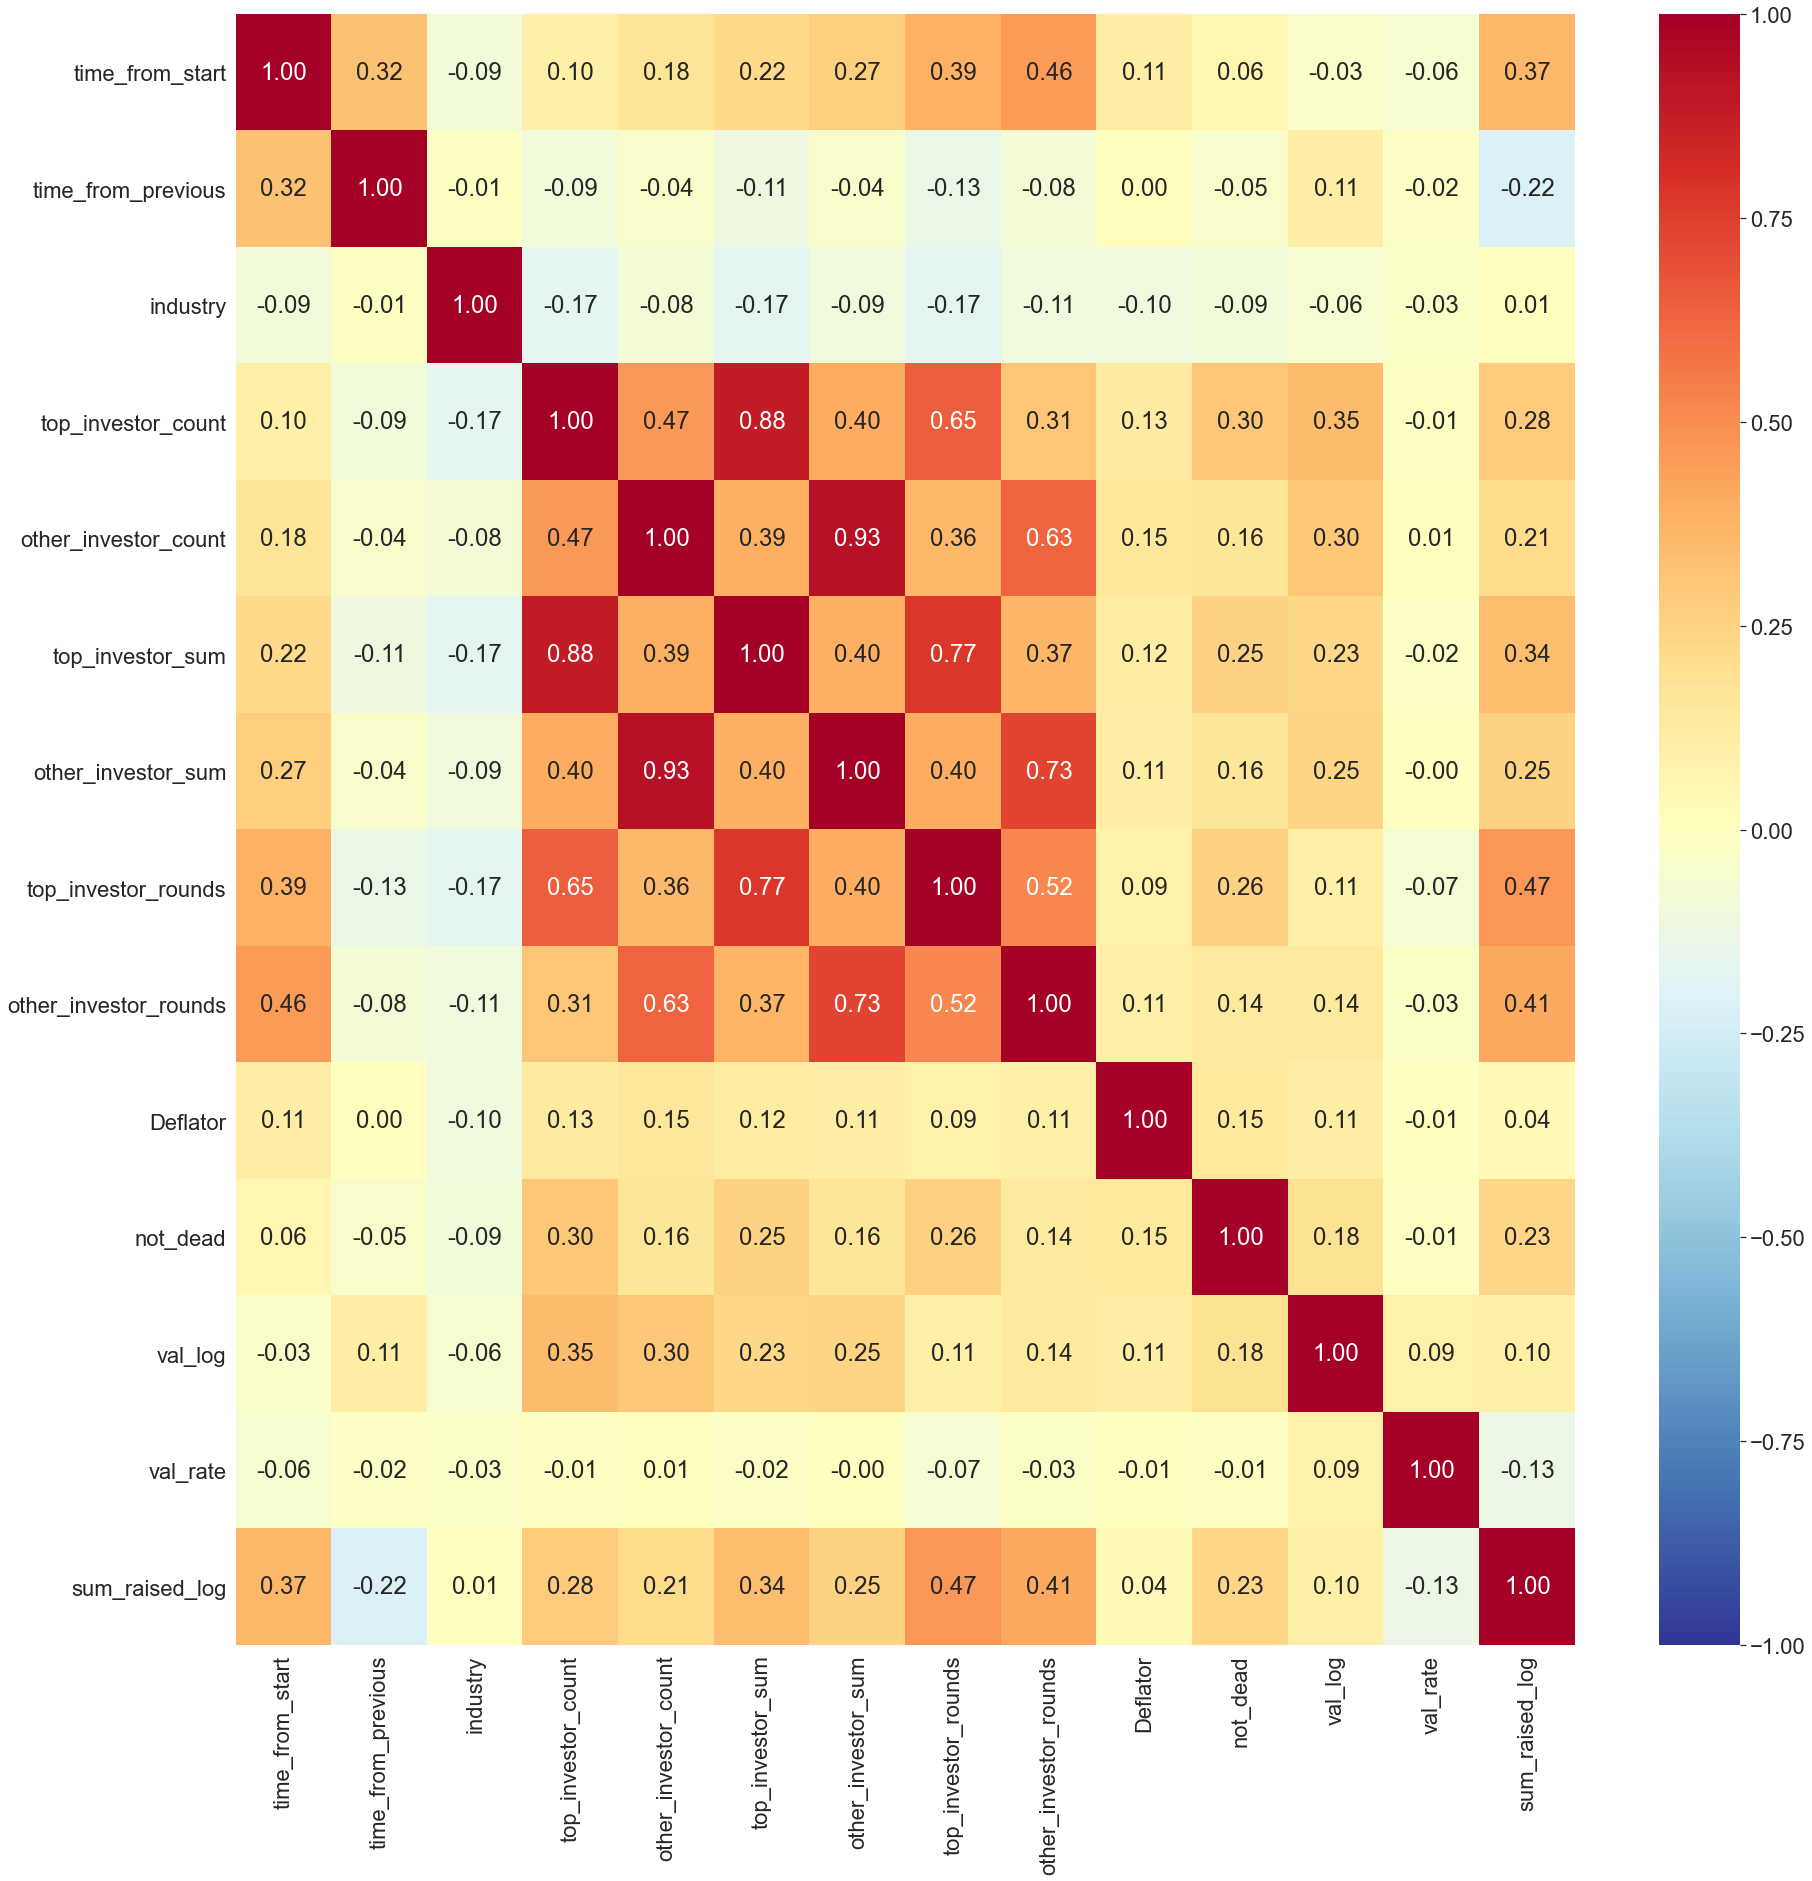

In [23]:
plt.figure(figsize=(30, 30))
sns.set(font_scale=2)
sns.heatmap(test_tab.corr(), annot=True, cmap='RdYlBu_r', vmin=-1, vmax=1, fmt='.2f')
#plt.savefig("heatmap.png")

In [19]:
# dates = dataset['announced_on'].dt.strftime('%Y-%m-%d')
# dates = dates.str[:4]
# dates = dates.values.astype(int)
# dates = dates.ravel()
# dates

In [20]:
# import itertools
# pair_ids = list(itertools.combinations(range(len(test_tab.columns)), 2))
# for pair in pair_ids:
#     plt.figure(figsize=(10, 10))
#     plt.scatter(test_tab.iloc[:, pair[0]], test_tab.iloc[:, pair[1]], c=dates, cmap='RdYlBu_r')
#     plt.xlabel(test_tab.iloc[:, pair[0]].name)
#     plt.ylabel(test_tab.iloc[:, pair[1]].name)
#     plt.grid()
#     plt.savefig("Plots/" + test_tab.iloc[:, pair[0]].name + " VS " + test_tab.iloc[:, pair[1]].name + ".png")

In [21]:
# classes = dataset.copy()
# classes.loc[classes['class'] == 'narwhal', 'class'] = 0
# classes.loc[classes['class'] == 'rhino', 'class'] = 1
# classes = classes['class'].values
# classes

In [22]:
# plt.figure(figsize=(10, 10))
# scatter = plt.scatter(dataset['time_from_previous'], dataset['log_delta'], c=classes, cmap='RdYlBu_r')
# plt.xlabel('time_from_previous')
# plt.ylabel('log_delta')
# plt.grid()
# plt.legend(handles=scatter.legend_elements()[0], labels=['narwhal', 'rhino'])
# plt.savefig("pre_exit_time_from_previous VS log_delta.png")

In [23]:
# plt.figure(figsize=(10, 10))
# scatter = plt.scatter(exits['time_from_previous'], exits['log_delta'], c=classes, cmap='RdYlBu_r')
# plt.xlabel('time_from_previous')
# plt.ylabel('log_delta')
# plt.grid()
# plt.legend(handles=scatter.legend_elements()[0], labels=['narwhal', 'rhino'])
# plt.savefig("exit_time_from_previous VS log_delta.png")

### Preprocessing

Создаем выборки

In [25]:
y = dataset[['not_dead']] # 'class' 'exit_type'
X = dataset.drop(columns=['Date', 'not_dead', 'exit_type', 'funding_round_uuid', 'company_name', 'company_uuid', 'investment_type', 'announced_on', 'raised_amount_usd', 'post_money_valuation_usd', 'exit_date', 'price_usd', 'money_raised_usd', 'interpolated_money_valuation_usd', 'total_sum_raised', 'valuation', 'total_sum_raised_before', 'log_delta', 'top_investor', 'other_investor'])

X = X[['val_log',
       'sum_raised_log',
       'industry',
       'val_rate',
       'time_from_previous',
       'time_from_start',
       'top_investor_count',
       'other_investor_count',
       'Deflator'#,
#        'Deflator_1M',
#        'Deflator_3M',
#        'Deflator_6M',
#        'Deflator_9M'
      ]]

In [26]:
# X_send = X.copy()
# X_send.columns = ['col1', 'col2', 'col3', 'col4', 'col5', 'col6', 'col7']
# X_send.to_csv('X_send_w2.csv', encoding = 'utf-8-sig')
# X_send

In [27]:
# y_send = y.copy()
# y_send.columns = ['answer']
# y_send.to_csv('y_send_w2.csv', encoding = 'utf-8-sig')
# y_send

In [28]:
features = X.columns
features

Index(['val_log', 'sum_raised_log', 'industry', 'val_rate',
       'time_from_previous', 'time_from_start', 'top_investor_count',
       'other_investor_count', 'Deflator'],
      dtype='object')

In [29]:
X = X.values.astype(np.float) #X = X.to_numpy(dtype=np.float)
print(X.shape)

(977, 9)


In [30]:
y = y.values.ravel() #y = y.to_numpy()
print(y.shape)

(977,)


In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

skaler = StandardScaler()
X_train_t = skaler.fit_transform(X_train)
X_test_t = skaler.transform(X_test)

In [32]:
# X_DEMO = DEMO_SET.drop(columns=['exit_type', 'funding_round_uuid', 'company_name', 'company_uuid', 'investment_type', 'announced_on', 'raised_amount_usd', 'post_money_valuation_usd', 'exit_date', 'price_usd', 'money_raised_usd', 'interpolated_money_valuation_usd', 'total_sum_raised', 'valuation', 'log_delta', 'top_investor', 'other_investor'])
# X_DEMO = X_DEMO[['val_log',
#         'sum_raised_log',
# #        'time_from_2009',
#         'val_rate',
#         'time_from_previous',
#         'time_from_start',
#         'top_investor_rounds',
#         'other_investor_rounds'
#         ]]

# X_DEMO = X_DEMO.values.astype(np.float)
# X_DEMO_t = skaler.transform(X_DEMO)

In [33]:
# X_DEMO2 = DEMO_SET2.drop(columns=['exit_type', 'funding_round_uuid', 'company_name', 'company_uuid', 'investment_type', 'announced_on', 'raised_amount_usd', 'post_money_valuation_usd', 'exit_date', 'price_usd', 'money_raised_usd', 'interpolated_money_valuation_usd', 'total_sum_raised', 'valuation', 'log_delta', 'top_investor', 'other_investor'])
# X_DEMO2 = X_DEMO2[['val_log',
#         'sum_raised_log',
# #        'time_from_2009',
#         'val_rate',
#         'time_from_previous',
#         'time_from_start',
#         'top_investor_rounds',
#         'other_investor_rounds'
#         ]]

# X_DEMO2 = X_DEMO2.values.astype(np.float)
# X_DEMO2_t = skaler.transform(X_DEMO2)

In [34]:
# X_DEMO_ALL = DEMO_SET_ALL.drop(columns=['exit_type', 'funding_round_uuid', 'company_name', 'company_uuid', 'investment_type', 'announced_on', 'raised_amount_usd', 'post_money_valuation_usd', 'exit_date', 'price_usd', 'money_raised_usd', 'interpolated_money_valuation_usd', 'total_sum_raised', 'valuation', 'log_delta', 'top_investor', 'other_investor'])
# X_DEMO_ALL = X_DEMO_ALL[['val_log',
#         'sum_raised_log',
# #        'time_from_2009',
#         'val_rate',
#         'time_from_previous',
#         'time_from_start',
#         'top_investor_rounds',
#         'other_investor_rounds'
#         ]]

# X_DEMO_ALL = X_DEMO_ALL.values.astype(np.float)
# X_DEMO_ALL_t = skaler.transform(X_DEMO_ALL)

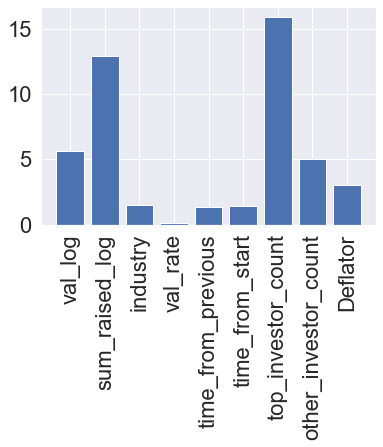

In [35]:
selector = SelectKBest(f_classif, k='all')
selector.fit(X_train_t, y_train)

#самый большой результат соответствует самому малому значению p-значения(вероятность ошибки)
#поэтому "переворачиваем", чтоб самые ценные признаки на графике были максимальными
scores = -np.log10(selector.pvalues_)

plt.bar(range(len(features)), scores)
plt.xticks(range(len(features)), features, rotation='vertical')
plt.show()

In [35]:
wave1_acc = []
wave1_PR = []
wave1_RC = []
wave1_features = []

### Sklearn Random Forest

In [36]:
param_grid = {
    'bootstrap': [True, False],
    'max_depth': [None, 25, 50, 75, 100],
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110]
}

estimator = RandomForestClassifier()
grid_search = GridSearchCV(estimator = estimator, param_grid = param_grid, cv = 5, n_jobs = -1, verbose = 2, scoring='accuracy')
grid_search.fit(X_train_t, y_train)
grid_search.best_params_

Fitting 5 folds for each of 990 candidates, totalling 4950 fits


{'bootstrap': False,
 'max_depth': 100,
 'min_samples_leaf': 2,
 'min_samples_split': 10,
 'n_estimators': 40}

In [37]:
acc_array = []
f1_array = []
PR_array = []
RC_array = []
feature_array = []
best_grid1 = grid_search.best_estimator_
for j in range(10):
    best_grid1.fit(X_train_t, y_train)
    predicted_labels = best_grid1.predict(X_test_t)
    acc = accuracy_score(y_test, predicted_labels)
    f1 = f1_score(y_test, predicted_labels, average = 'macro')
    PR = precision_score(y_test, predicted_labels, average = 'macro')
    RC = recall_score(y_test, predicted_labels, average = 'macro')
    acc_array.append(acc)
    PR_array.append(PR)
    RC_array.append(RC)
    f1_array.append(f1)
    feature_array.append(best_grid1.feature_importances_)
print(f'acc = {np.mean(acc_array)}')
print(f'PR = {np.mean(PR_array)}')
print(f'RC = {np.mean(RC_array)}')
print(f'f1 = {np.mean(f1_array)}')

acc = 0.713265306122449
PR = 0.7105266664361266
RC = 0.7129598308668077
f1 = 0.7109063092623291


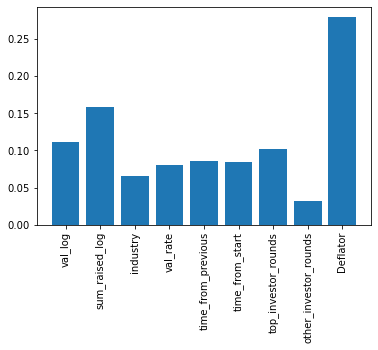

In [38]:
plt.bar(range(len(features)), best_grid1.feature_importances_)
plt.xticks(range(len(features)), features, rotation='vertical')
plt.show()

In [39]:
wave1_acc.append(np.mean(acc_array))
wave1_PR.append(np.mean(PR_array))
wave1_RC.append(np.mean(RC_array))
wave1_features.append(np.average(feature_array, axis=0))

### Sklearn Gradient Boosting

In [40]:
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.3],
    'max_depth': [None, 25, 50, 75, 100],
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [20, 50, 60, 70, 80, 90, 100, 110]
}

estimator = GradientBoostingClassifier()
grid_search = GridSearchCV(estimator = estimator, param_grid = param_grid, cv = 5, n_jobs = -1, verbose = 2, scoring='accuracy')
grid_search.fit(X_train_t, y_train)
grid_search.best_params_

Fitting 5 folds for each of 1440 candidates, totalling 7200 fits


{'learning_rate': 0.3,
 'max_depth': 100,
 'min_samples_leaf': 3,
 'min_samples_split': 2,
 'n_estimators': 70}

In [41]:
acc_array = []
f1_array = []
PR_array = []
RC_array = []
feature_array = []
best_grid2 = grid_search.best_estimator_
for j in range(10):
    best_grid2.fit(X_train_t, y_train)
    predicted_labels = best_grid2.predict(X_test_t)
    acc = accuracy_score(y_test, predicted_labels)
    f1 = f1_score(y_test, predicted_labels, average = 'macro')
    PR = precision_score(y_test, predicted_labels, average = 'macro')
    RC = recall_score(y_test, predicted_labels, average = 'macro')
    acc_array.append(acc)
    PR_array.append(PR)
    RC_array.append(RC)
    f1_array.append(f1)
    feature_array.append(best_grid2.feature_importances_)
print(f'acc = {np.mean(acc_array)}')
print(f'PR = {np.mean(PR_array)}')
print(f'RC = {np.mean(RC_array)}')
print(f'f1 = {np.mean(f1_array)}')

acc = 0.6948979591836735
PR = 0.6910221877770443
RC = 0.6920295983086681
f1 = 0.6912218380184689


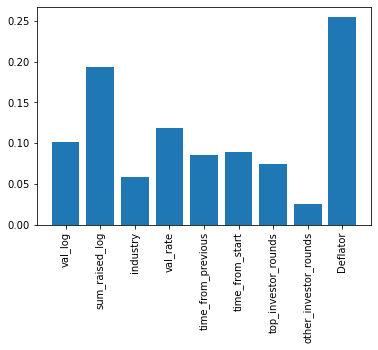

In [42]:
plt.bar(range(len(features)), best_grid2.feature_importances_)
plt.xticks(range(len(features)), features, rotation='vertical')
plt.show()

In [43]:
wave1_acc.append(np.mean(acc_array))
wave1_PR.append(np.mean(PR_array))
wave1_RC.append(np.mean(RC_array))
wave1_features.append(np.average(feature_array, axis=0))

### XGBoost

In [44]:
param_grid = {
    "max_depth": [3, 4, 5, 7],
    "learning_rate": [0.1, 0.01, 0.05],
    "gamma": [0, 0.25, 1],
    "reg_lambda": [0, 1, 10],
    "scale_pos_weight": [1, 3, 5],
    "subsample": [0.8],
    "colsample_bytree": [0.5],
}

estimator = XGBClassifier(objective="binary:logistic")
grid_search = GridSearchCV(estimator, param_grid, n_jobs=-1, cv=3, scoring="accuracy") #verbose = 2, scoring='accuracy' roc_auc
grid_search.fit(X_train_t, y_train)
grid_search.best_params_

[21:40:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Barca\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


{'colsample_bytree': 0.5,
 'gamma': 0.25,
 'learning_rate': 0.1,
 'max_depth': 3,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'subsample': 0.8}

In [45]:
grid_search.best_score_

0.7464240102171137

In [46]:
# best_grid3 = grid_search.best_estimator_
best_grid3 = XGBClassifier(objective="binary:logistic", **grid_search.best_params_)
best_grid3.fit(X_train_t, y_train)

[21:40:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0.25, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=12, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.8,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [47]:
predicted_labels = best_grid3.predict(X_test_t)

roc_auc = roc_auc_score(y_test, predicted_labels)
acc = accuracy_score(y_test, predicted_labels)
f1 = f1_score(y_test, predicted_labels, average = 'macro')
PR = precision_score(y_test, predicted_labels, average = 'macro')
RC = recall_score(y_test, predicted_labels, average = 'macro')

print(f'acc = {acc}')
print(f'PR = {PR}')
print(f'RC = {RC}')
print(f'f1 = {f1}')

acc = 0.7244897959183674
PR = 0.7209643605870022
RC = 0.7228329809725158
f1 = 0.7215909090909092


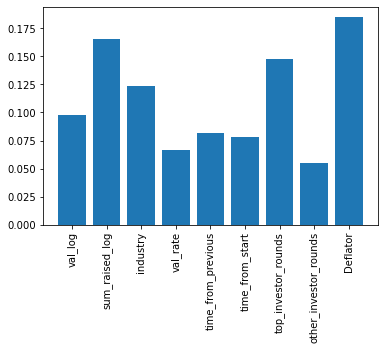

In [48]:
plt.bar(range(len(features)), best_grid3.feature_importances_)
plt.xticks(range(len(features)), features, rotation='vertical')
plt.show()

In [49]:
wave1_acc.append(acc)
wave1_PR.append(PR)
wave1_RC.append(RC)
wave1_features.append(best_grid3.feature_importances_)

In [50]:
wave1_acc

[0.713265306122449, 0.6948979591836735, 0.7244897959183674]

In [51]:
wave1_PR

[0.7105266664361266, 0.6910221877770443, 0.7209643605870022]

In [52]:
wave1_RC

[0.7129598308668077, 0.6920295983086681, 0.7228329809725158]

In [53]:
wave1_features

[array([0.11063899, 0.17172727, 0.06866564, 0.08215064, 0.08019806,
        0.07921685, 0.09884695, 0.03451529, 0.2740403 ]),
 array([0.10058435, 0.20178495, 0.05797746, 0.11204079, 0.08607779,
        0.09305015, 0.07182182, 0.02928308, 0.24737961]),
 array([0.09739404, 0.16562419, 0.12349172, 0.06661185, 0.08191899,
        0.07810103, 0.14752458, 0.05451992, 0.18481371], dtype=float32)]

In [54]:
wave1real_df = pd.DataFrame(list(zip([wave1_acc[0]], [wave1_acc[1]], [wave1_acc[2]])), 
               columns =['Random Forest', 'Gradient Boosting', 'XGBoost Classifier'])
wave1realf_df = pd.DataFrame(list(zip(wave1_features[0], wave1_features[1], wave1_features[2])), 
               columns =['Random Forest', 'Gradient Boosting', 'XGBoost Classifier'])
features = features.insert(0, 'ACCURACY')
parameters = pd.DataFrame(list(features), columns =['Parameter'])
wave1real_df = wave1real_df.append(wave1realf_df).reset_index(drop=True)
wave1real_df = pd.concat([parameters, wave1real_df], axis=1)
wave1real_df.to_csv('wave2_results_def.csv', encoding = 'utf-8-sig')
wave1real_df

,Parameter,Random Forest,Gradient Boosting,XGBoost Classifier
0,ACCURACY,0.713265,0.694898,0.724490
1,val_log,0.110639,0.100584,0.097394
2,sum_raised_log,0.171727,0.201785,0.165624
3,industry,0.068666,0.057977,0.123492
4,val_rate,0.082151,0.112041,0.066612
5,time_from_previous,0.080198,0.086078,0.081919
6,time_from_start,0.079217,0.093050,0.078101
7,top_investor_rounds,0.098847,0.071822,0.147525
8,other_investor_rounds,0.034515,0.029283,0.054520
9,Deflator,0.274040,0.247380,0.184814


In [55]:
predicted_labels1 = best_grid1.predict(X_DEMO_t)
predicted_labels2 = best_grid2.predict(X_DEMO_t)
predicted_labels3 = best_grid3.predict(X_DEMO_t)

In [56]:
a = pd.DataFrame(list(predicted_labels1), columns =['Random_Forest'])
b = pd.DataFrame(list(predicted_labels2), columns =['Gradient_Boosting'])
c = pd.DataFrame(list(predicted_labels3), columns =['XGBoost_Classifier'])
demo = pd.concat([DEMO_SET[['company_name']].reset_index(drop=True), a, b, c], axis=1)
#demo.to_csv('forecast_w2.csv', encoding = 'utf-8-sig')
demo

,company_name,Random_Forest,Gradient_Boosting,XGBoost_Classifier
0,Roblox Corporation,0.0,0.0,1.0
1,Lemonade,1.0,1.0,1.0
2,Palantir Technologies,1.0,1.0,1.0
3,DoorDash,1.0,1.0,1.0
4,JFrog,1.0,0.0,1.0
5,Unity Technologies,1.0,1.0,1.0
6,Sumo Logic,1.0,1.0,1.0
7,Snowflake Computing,1.0,1.0,1.0
8,Airbnb,1.0,1.0,1.0
9,Asana,1.0,1.0,1.0


In [57]:
predicted_labels1 = best_grid1.predict(X_DEMO2_t)
predicted_labels2 = best_grid2.predict(X_DEMO2_t)
predicted_labels3 = best_grid3.predict(X_DEMO2_t)

In [58]:
a = pd.DataFrame(list(predicted_labels1), columns =['Random_Forest'])
b = pd.DataFrame(list(predicted_labels2), columns =['Gradient_Boosting'])
c = pd.DataFrame(list(predicted_labels3), columns =['XGBoost_Classifier'])
demo = pd.concat([DEMO_SET2[['company_name']].reset_index(drop=True), a, b, c], axis=1)
#demo.to_csv('forecast_w2_2.csv', encoding = 'utf-8-sig')
demo

,company_name,Random_Forest,Gradient_Boosting,XGBoost_Classifier
0,VertiFlex,1.0,1.0,1.0
1,mitú,1.0,1.0,1.0
2,Postmates,1.0,1.0,1.0
3,Calient Technologies,0.0,1.0,1.0
4,Kyriba Corporation,1.0,0.0,0.0
5,Vidyo,0.0,0.0,1.0
6,littleBits Electronics,1.0,1.0,1.0
7,Harry's,1.0,1.0,1.0
8,Numerify,1.0,1.0,1.0
9,Whistle Sports,1.0,1.0,1.0


In [59]:
predicted_labels1 = best_grid1.predict(X_DEMO_ALL_t)
predicted_labels2 = best_grid2.predict(X_DEMO_ALL_t)
predicted_labels3 = best_grid3.predict(X_DEMO_ALL_t)

In [60]:
a = pd.DataFrame(list(predicted_labels1), columns =['Random_Forest'])
b = pd.DataFrame(list(predicted_labels2), columns =['Gradient_Boosting'])
c = pd.DataFrame(list(predicted_labels3), columns =['XGBoost_Classifier'])
demo = pd.concat([DEMO_SET_ALL[['company_name']].reset_index(drop=True), a, b, c], axis=1)
demo.to_csv('forecast_w2_all.csv', encoding = 'utf-8-sig')
demo

,company_name,Random_Forest,Gradient_Boosting,XGBoost_Classifier
0,BioAtla LLC,0.0,0.0,1.0
1,Lot18,0.0,0.0,0.0
2,Xcovery,0.0,0.0,0.0
3,HeartFlow,1.0,1.0,1.0
4,Udacity,1.0,1.0,1.0
...,...,...,...,...
2382,PowerVision,0.0,0.0,0.0
2383,Sisense,1.0,1.0,1.0
2384,IlluminOss Medical,0.0,0.0,0.0
2385,Checkr,1.0,1.0,1.0


### На единичных признаках

In [33]:
y = dataset[['not_dead']]
y = y.values.ravel()
X_general = dataset.drop(columns=['class', 'not_dead', 'exit_type', 'funding_round_uuid', 'company_name', 'company_uuid', 'investment_type', 'announced_on', 'raised_amount_usd', 'post_money_valuation_usd', 'exit_date', 'price_usd', 'money_raised_usd', 'interpolated_money_valuation_usd', 'total_sum_raised', 'valuation', 'log_delta', 'top_investor', 'other_investor'])

skaler = StandardScaler()
param_grid = {
    'bootstrap': [True, False], #rf only
#    'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], #boosting only
    'max_depth': [None, 25, 50, 75, 100],
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110]
}
estimator = RandomForestClassifier() #0.65-0.71
#estimator = GradientBoostingClassifier() #0.6-0.66
grid_search = GridSearchCV(estimator = estimator, param_grid = param_grid, cv = 5, n_jobs = -1, verbose = 2, scoring='accuracy')

X_general.columns

Index(['time_from_2009', 'time_from_start', 'time_from_previous',
       'top_investor_count', 'other_investor_count', 'top_investor_sum',
       'other_investor_sum', 'top_investor_rounds', 'other_investor_rounds',
       'total_sum_raised_before', 'valuation', 'log_rate'],
      dtype='object')

In [34]:
mean_acc = []
mean_f1 = []
features = ['time_from_2009', 'time_from_start', 'time_from_previous',
       'top_investor_count', 'other_investor_count', 'top_investor_sum',
       'other_investor_sum', 'top_investor_rounds', 'other_investor_rounds',
       'sum_raised_log', 'val_log', 'val_rate']
for i in features:
    X = X_general[[i]]
    X = X.values.astype(np.float)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    X_train_t = skaler.fit_transform(X_train)
    X_test_t = skaler.transform(X_test)
    grid_search.fit(X_train_t, y_train)
    best_grid = grid_search.best_estimator_
    
    acc_array = []
    f1_array = []
    PR_array = []
    RC_array = []
    for j in range(10):
        best_grid.fit(X_train_t, y_train)
        predicted_labels = best_grid.predict(X_test_t)
        acc = accuracy_score(y_test, predicted_labels)
        f1 = f1_score(y_test, predicted_labels, average = 'macro')
        PR = precision_score(y_test, predicted_labels, average = 'macro')
        RC = recall_score(y_test, predicted_labels, average = 'macro')
        acc_array.append(acc)
        PR_array.append(PR)
        RC_array.append(RC)
        f1_array.append(f1)
    mean_acc.append(np.mean(acc_array))
    mean_f1.append(np.mean(f1_array))
    #print(f'acc on {i} = {np.mean(acc_array)}')
    #print(f'f1 on {i} = {np.mean(f1_array)}')
mean_acc_f1_df = pd.DataFrame(list(zip(mean_acc, mean_f1)), 
               columns =['Accuracy', 'F-Score']).set_index([features])
print(mean_acc_f1_df)

Fitting 5 folds for each of 990 candidates, totalling 4950 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 216 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 1028 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done 3620 tasks      | elapsed:   37.1s
[Parallel(n_jobs=-1)]: Done 4950 out of 4950 | elapsed:   50.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 5 folds for each of 990 candidates, totalling 4950 fits


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 252 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 658 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 1224 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done 1954 tasks      | elapsed:   20.0s
[Parallel(n_jobs=-1)]: Done 2844 tasks      | elapsed:   29.0s
[Parallel(n_jobs=-1)]: Done 3898 tasks      | elapsed:   39.6s
[Parallel(n_jobs=-1)]: Done 4950 out of 4950 | elapsed:   50.3s finished


Fitting 5 folds for each of 990 candidates, totalling 4950 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 252 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 658 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 1224 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done 1954 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done 2844 tasks      | elapsed:   28.5s
[Parallel(n_jobs=-1)]: Done 3898 tasks      | elapsed:   38.6s
[Parallel(n_jobs=-1)]: Done 4950 out of 4950 | elapsed:   48.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 5 folds for each of 990 candidates, totalling 4950 fits


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 252 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 658 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 1224 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 1954 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 2844 tasks      | elapsed:   22.4s
[Parallel(n_jobs=-1)]: Done 3898 tasks      | elapsed:   28.8s
[Parallel(n_jobs=-1)]: Done 4950 out of 4950 | elapsed:   35.3s finished


Fitting 5 folds for each of 990 candidates, totalling 4950 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 252 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 658 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 1224 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 1954 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done 2844 tasks      | elapsed:   22.9s
[Parallel(n_jobs=-1)]: Done 3898 tasks      | elapsed:   29.5s
[Parallel(n_jobs=-1)]: Done 4950 out of 4950 | elapsed:   36.5s finished


Fitting 5 folds for each of 990 candidates, totalling 4950 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 252 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 658 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 1224 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 1954 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done 2844 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done 3898 tasks      | elapsed:   29.9s
[Parallel(n_jobs=-1)]: Done 4950 out of 4950 | elapsed:   36.7s finished


Fitting 5 folds for each of 990 candidates, totalling 4950 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 252 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 658 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 1224 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 1954 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done 2844 tasks      | elapsed:   23.3s
[Parallel(n_jobs=-1)]: Done 3898 tasks      | elapsed:   30.1s
[Parallel(n_jobs=-1)]: Done 4950 out of 4950 | elapsed:   36.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 5 folds for each of 990 candidates, totalling 4950 fits


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 252 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 658 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 1224 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 1954 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 2844 tasks      | elapsed:   22.3s
[Parallel(n_jobs=-1)]: Done 3898 tasks      | elapsed:   28.8s
[Parallel(n_jobs=-1)]: Done 4950 out of 4950 | elapsed:   35.3s finished


Fitting 5 folds for each of 990 candidates, totalling 4950 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 252 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 658 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 1224 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 1954 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 2844 tasks      | elapsed:   22.4s
[Parallel(n_jobs=-1)]: Done 3898 tasks      | elapsed:   28.8s
[Parallel(n_jobs=-1)]: Done 4950 out of 4950 | elapsed:   35.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 5 folds for each of 990 candidates, totalling 4950 fits


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 252 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 658 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 1224 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done 1954 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done 2844 tasks      | elapsed:   27.0s
[Parallel(n_jobs=-1)]: Done 3898 tasks      | elapsed:   36.1s
[Parallel(n_jobs=-1)]: Done 4950 out of 4950 | elapsed:   45.2s finished


Fitting 5 folds for each of 990 candidates, totalling 4950 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 252 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 658 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 1224 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 1954 tasks      | elapsed:   17.6s
[Parallel(n_jobs=-1)]: Done 2844 tasks      | elapsed:   25.4s
[Parallel(n_jobs=-1)]: Done 3898 tasks      | elapsed:   33.6s
[Parallel(n_jobs=-1)]: Done 4950 out of 4950 | elapsed:   41.8s finished


Fitting 5 folds for each of 990 candidates, totalling 4950 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 252 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 658 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 1224 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done 1954 tasks      | elapsed:   19.9s
[Parallel(n_jobs=-1)]: Done 2844 tasks      | elapsed:   29.6s
[Parallel(n_jobs=-1)]: Done 3898 tasks      | elapsed:   41.2s
[Parallel(n_jobs=-1)]: Done 4950 out of 4950 | elapsed:   52.9s finished


                         Accuracy   F-Score
time_from_2009           0.561538  0.557030
time_from_start          0.503077  0.496843
time_from_previous       0.518462  0.507093
top_investor_count       0.620513  0.615159
other_investor_count     0.584103  0.549638
top_investor_sum         0.548718  0.546877
other_investor_sum       0.527692  0.507549
top_investor_rounds      0.579487  0.526923
other_investor_rounds    0.602051  0.559214
total_sum_raised_before  0.567179  0.540938
valuation                0.601538  0.590419
log_rate                 0.480000  0.463055


In [35]:
mean_acc_f1_df

,Accuracy,F-Score
time_from_2009,0.561538,0.557030
time_from_start,0.503077,0.496843
time_from_previous,0.518462,0.507093
top_investor_count,0.620513,0.615159
other_investor_count,0.584103,0.549638
top_investor_sum,0.548718,0.546877
other_investor_sum,0.527692,0.507549
top_investor_rounds,0.579487,0.526923
other_investor_rounds,0.602051,0.559214
total_sum_raised_before,0.567179,0.540938


In [76]:
# acc_train = []
# acc_test = []
# f1_train = []
# f1_test = []
# for i in range(1, 101):
#     #classifier = LogisticRegression(solver='saga', multi_class='multinomial', max_iter=100, C=0.12, penalty='l1', n_jobs=-1) #меньше 0.6
#     #classifier = KNeighborsClassifier(n_neighbors=20, weights='distance', n_jobs =-1) #отвратительное качество
#     classifier = DecisionTreeClassifier(max_depth=100) #качество на уровне 0.65-0.7
    
#     #ensemble_classifier = BaggingClassifier(base_estimator=classifier, n_estimators=i, bootstrap=True, n_jobs=-1)
#     ensemble_classifier = RandomForestClassifier(n_estimators=i, n_jobs=-1) #качество на уровне 0.65-0.7
#     #ensemble_classifier = GradientBoostingClassifier(n_estimators=i, learning_rate=0.2, max_depth=10) #качество на уровне 0.6-0.7
    
#     ensemble_classifier.fit(X_train_t, y_train)
#     class_names = ensemble_classifier.classes_
#     y_train_b = label_binarize(y_train, class_names)
#     y_test_b = label_binarize(y_test, class_names)
#     y_predict_train_b = label_binarize(ensemble_classifier.predict(X_train_t), class_names)
#     y_predict_test_b = label_binarize(ensemble_classifier.predict(X_test_t), class_names)
#     acc_train.append(accuracy_score(y_train_b, y_predict_train_b))
#     f1_train.append(f1_score(y_train_b, y_predict_train_b, average='weighted'))
#     acc_test.append(accuracy_score(y_test_b, y_predict_test_b))
#     f1_test.append(f1_score(y_test_b, y_predict_test_b, average='weighted'))

# plt.figure(figsize=(7, 7))
# plt.plot(np.arange(1, 101), acc_train, label='accuracy train')
# plt.plot(np.arange(1, 101), f1_train, label='f1_score train')
# plt.plot(np.arange(1, 101), acc_test, label='accuracy test')
# plt.plot(np.arange(1, 101), f1_test, label='f1_score test')
# plt.xlabel('n_estimators')
# plt.ylabel('score')
# plt.legend()
# plt.grid()
# plt.show()

### LogReg, kNN, Decision Tree

In [17]:
#pg = {'C': np.linspace(0.01, 1, 10), 'penalty': ['l1', 'l2']}
#pg = {'n_neighbors': range(1, 21)}
#pg = {'max_depth': np.linspace(1, 100, 5)}

#classifier = LogisticRegression(solver='saga', multi_class='multinomial', max_iter=1000, n_jobs =-1) #lbfgs
#classifier = KNeighborsClassifier(weights='distance')
#classifier = DecisionTreeClassifier()

#grid_search = GridSearchCV(estimator=classifier, n_jobs = -1, param_grid=pg, cv=5, scoring='accuracy')
#grid_search.fit(X_train_t, y_train)

#grid_search.best_params_

In [18]:
#best_classifier = grid_search.best_estimator_
#best_classifier.fit(X_train_t, y_train)

In [19]:
#predicted_labels = best_classifier.predict(X_test_t)

#acc = accuracy_score(y_test, predicted_labels)
#print(f'acc = {acc}')
#f1 = f1_score(y_test, predicted_labels, average = 'macro')
#print(f'f1 = {f1}')

In [20]:
#predict_proba = grid_search.predict_proba(X_test_t)
#for i in predict_proba:
#    print(i)

In [21]:
#class_names = grid_search.best_estimator_.classes_
#y_predict = grid_search.predict_proba(X_test_t)

##y_test_b = label_binarize(y_test, class_names)
#lb = LabelBinarizer()
#y_test_b = lb.fit_transform(y_test)
#y_test_b = np.hstack((1 - y_test_b, y_test_b))

#fpr = dict()
#tpr = dict()
#roc_auc = dict()
#for i in range(len(class_names)):
#    fpr[i], tpr[i], _ = roc_curve(y_test_b[:, i], y_predict[:, i])
#    roc_auc[i] = auc(fpr[i], tpr[i])
    
##для микро
#fpr['micro'], tpr['micro'], _ = roc_curve(y_test_b.ravel(), y_predict.ravel())
#roc_auc['micro'] = auc(fpr['micro'], tpr['micro'])

##макро
#all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(class_names))]))
#mean_tpr = np.zeros_like(all_fpr)
#for i in range(len(class_names)):
#    mean_tpr += interp(all_fpr, fpr[i], tpr[i]) 
#mean_tpr /= len(class_names)
#fpr['macro'] = all_fpr
#tpr['macro'] = mean_tpr
#roc_auc['macro'] = auc(fpr['macro'], tpr['macro'])

##графики
#plt.figure(figsize=(6,6))
#plt.plot(fpr['micro'], tpr['micro'], label='micro, auc = %.3f'%(roc_auc['micro']), linestyle='--')
#plt.plot(fpr['macro'], tpr['macro'], label='macro, auc = %.3f'%(roc_auc['macro']), linestyle='--')
#for i in range(len(class_names)):
#    plt.plot(fpr[i], tpr[i], label='class = %s, auc = %.3f'%(class_names[i], auc(fpr[i], tpr[i])))

#plt.title('ROC-Кривая')
#plt.xlabel('False Positive Rate')
#plt.ylabel('True Positive Rate')
#plt.legend()
#plt.show()

### Сокращение размерности

In [34]:
#pca = PCA()
#pca.fit(X_train_t)

#variance = np.cumsum(pca.explained_variance_ratio_)

#plt.figure(figsize=(5,5))
#plt.plot(variance)
#plt.xlabel('Components')
#plt.ylabel('EVR')
#plt.plot([0,46],[0.95,0.95])
#plt.show()

In [35]:
#pca = PCA(n_components=39)

#X_train_pca = pca.fit_transform(X_train_t)
#X_test_pca = pca.transform(X_test_t)

In [36]:
#pg = {'C': np.linspace(0.01, 1, 10), 'penalty': ['l1', 'l2']}
#pg = {'n_neighbors': range(1, 31)}
#pg = {'max_depth': np.linspace(1, 100, 5)}

In [37]:
#classifier = LogisticRegression(solver='saga', multi_class='multinomial', max_iter=100, n_jobs =-1) #lbfgs
#classifier = KNeighborsClassifier(weights='distance')
#classifier = DecisionTreeClassifier()

#grid_search = GridSearchCV(estimator=classifier, n_jobs = -1, param_grid=pg, cv=5, scoring='accuracy')
#grid_search.fit(X_train_pca, y_train)

#grid_search.best_params_

In [38]:
#predicted_labels = grid_search.predict(X_test_pca)

#acc = accuracy_score(y_test, predicted_labels)
#f1 = f1_score(y_test, predicted_labels, average='weighted')
#print('acc = ', acc)
#print('f1 = ', f1)

### Catboost

In [63]:
y = dataset[['not_dead']] #'not_dead' 'exit_type' 'class'
X = dataset.drop(columns=['class', 'not_dead', 'exit_type', 'top_investor', 'other_investor', 'total_sum_raised', 'first_last_dif', 'stadia', 'investment_type', 'log_delta', 'price_usd', 'money_raised_usd', 'exp_months_std', 'funding_round_uuid', 'company_name', 'company_uuid', 'announced_on', 'exit_date', 'total_count', 'count_per_round', 'raised_amount_usd', 'post_money_valuation_usd', 'interpolated_money_valuation_usd', 'valuation'])

#только признаки команды (образование + опыт)
#X = X.drop(columns=['time_from_2009', 'time_from_previous', 'time_from_start', 'top_investor_sum', 'other_investor_sum', 'sum_raised_log', 'valuation', 'val_rate'])

#только инвестора и раунды
X = X[['val_log', 'val_rate', 'sum_raised_log', 'time_from_2009', 'time_from_previous', 'time_from_start', 'top_investor_sum', 'other_investor_sum']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_eval, y_train, y_eval = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

skaler = StandardScaler()
X_train_t = skaler.fit_transform(X_train)
X_eval_t = skaler.fit_transform(X_eval)
X_test_t = skaler.transform(X_test)

In [64]:
model = CatBoostClassifier(has_time=True, iterations=1000, depth=10, learning_rate=0.1, loss_function='CrossEntropy')
model.fit(X_train_t, y_train, eval_set=(X_eval_t, y_eval), verbose=100)

print ('CatBoost: prediction of %s: RMSLE on test = %s' % ('not_dead', model.evals_result_['validation']['CrossEntropy'][-1]))

0:	learn: 0.6514671	test: 0.6741755	best: 0.6741755 (0)	total: 155ms	remaining: 2m 34s
100:	learn: 0.0489779	test: 0.6215706	best: 0.5913487 (16)	total: 1.58s	remaining: 14.1s
200:	learn: 0.0177040	test: 0.6744059	best: 0.5913487 (16)	total: 2.9s	remaining: 11.6s
300:	learn: 0.0101371	test: 0.7124593	best: 0.5913487 (16)	total: 4.2s	remaining: 9.76s
400:	learn: 0.0069237	test: 0.7399347	best: 0.5913487 (16)	total: 5.55s	remaining: 8.29s
500:	learn: 0.0053840	test: 0.7578491	best: 0.5913487 (16)	total: 6.87s	remaining: 6.84s
600:	learn: 0.0044076	test: 0.7763442	best: 0.5913487 (16)	total: 8.21s	remaining: 5.45s
700:	learn: 0.0038291	test: 0.7896251	best: 0.5913487 (16)	total: 9.62s	remaining: 4.1s
800:	learn: 0.0033698	test: 0.7988073	best: 0.5913487 (16)	total: 10.9s	remaining: 2.72s
900:	learn: 0.0030590	test: 0.8067507	best: 0.5913487 (16)	total: 12.3s	remaining: 1.35s
999:	learn: 0.0028825	test: 0.8127623	best: 0.5913487 (16)	total: 13.7s	remaining: 0us

bestTest = 0.5913486676
bes

In [65]:
y_pred = model.predict(X_test_t)
y_pred

array([1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0],
      dtype=int64)

In [66]:
y_test = y_test.values.ravel()
y_test

array([1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1., 1.,
       1., 1., 0., 1., 1., 1., 0., 0., 0., 0., 1., 0., 1., 0., 1., 1., 1.,
       0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1.,
       1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 0., 0., 1., 1.,
       0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1.,
       1., 0., 1., 1., 1., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 1., 0.,
       1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1.,
       0., 1., 1., 1., 0., 0., 1., 1., 0., 1., 0., 1.])

In [67]:
print ('\nCatBoost: prediction of %s. Feature importance. Type=PredictionValuesChange' % 'log_delta')
print (model.get_feature_importance(type=cb.EFstrType.PredictionValuesChange, prettified=True).head(25).to_string())


CatBoost: prediction of log_delta. Feature importance. Type=PredictionValuesChange
  Feature Id  Importances
0          6    19.197516
1          3    18.696240
2          0    17.847655
3          7    12.064020
4          2     9.962412
5          4     8.120351
6          5     7.730078
7          1     6.381729


In [68]:
model.score(X_test_t, y_test)

0.6564885496183206